In [1]:
#imports and check 
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from glob import glob


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#metadata set based on images 
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [3]:
skin_image_dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"

#make a copy of meta-datdjsu
df = meta_data.copy()

In [4]:
#check we got the right dir 
if os.path.exists(skin_image_dir):
    print(f"The directory '{skin_image_dir}' exists.")
    
    # check a few image files from the directory to confirm its contents
    image_files = [f for f in os.listdir(skin_image_dir) if f.endswith('.jpg')]
    
    # display the first few image filenames (for instance, the first 5)
    print("First few image files:")
    for img in image_files[:5]:
        print(img)
else:
    print(f"The directory '{skin_image_dir}' does not exist.")

The directory '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer' exists.
First few image files:
ISIC_0030912.jpg
ISIC_0028933.jpg
ISIC_0030585.jpg
ISIC_0028394.jpg
ISIC_0033697.jpg


In [5]:
#get ids and image path for df 
ids = [x.split('.')[0] for x in os.listdir(skin_image_dir)]
image_path = {x:os.path.join(skin_image_dir,f'{x}.jpg') for x in ids}

#lets make a dict that changes maps the abbreviations for dx - more easier to understand what we are looking at 
lesion_classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis lesions ',
    'bcc': 'BC carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular',
    'df': 'Dermatofibroma'
}


In [6]:
# renaming dx types to respective names
df['dx'] = df['dx'].map(lesion_classes)

# adding column to categorical lesion type
df['lesion_class'] = pd.Categorical(df['dx']).codes

# adding image files to path in respect to image_id 
df['img_dir'] = df['image_id'].map(image_path.get)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_class,img_dir
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...


In [7]:
#lets map the actually image to the dir now and resize accordingly 
df['image'] = df['img_dir'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [8]:
#check for null vals
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
lesion_class     0
img_dir          0
image            0
dtype: int64

In [9]:
#impute the mean age in for nulls vals 
df['age'] = df['age'].fillna(df['age'].mean())
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
lesion_class    0
img_dir         0
image           0
dtype: int64

In [10]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_class,img_dir,image
0,HAM_0000118,ISIC_0027419,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,Benign keratosis lesions,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,Benign keratosis lesions,histo,75.0,male,ear,2,/kaggle/input/skin-cancer-dataset/Skin Cancer/...,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


Lets do some exploratory data analysis 


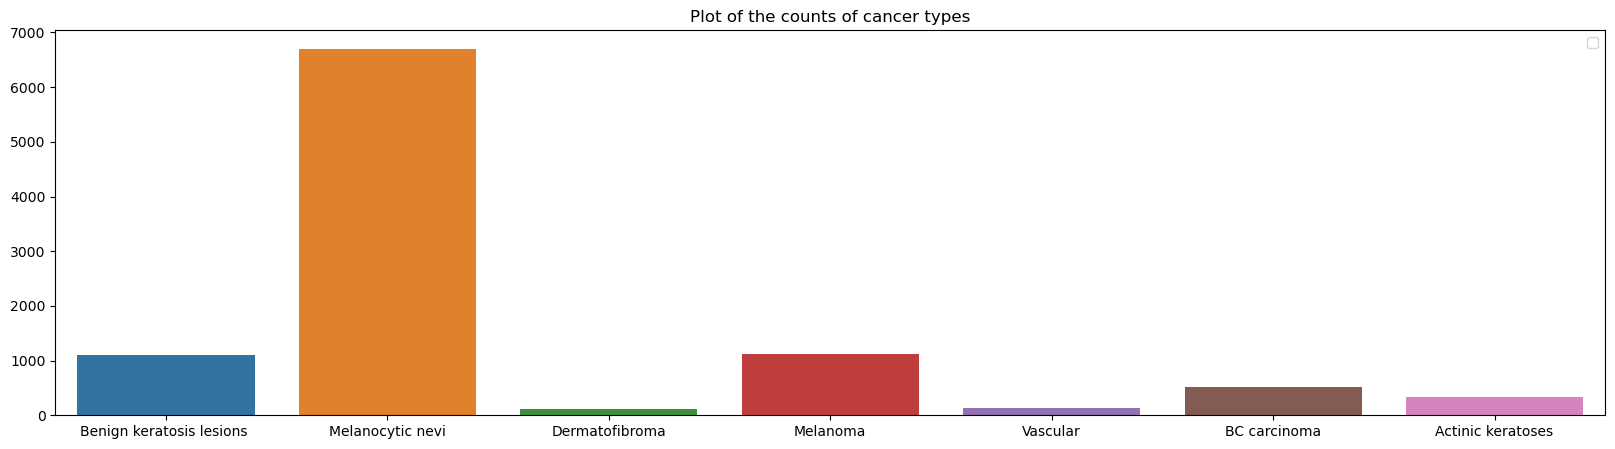

In [11]:
#lets plot the number of counts for cancer types
plt.figure(figsize=(20,5))
sns.countplot(x='dx',data=df)
plt.title("Plot of the counts of cancer types")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

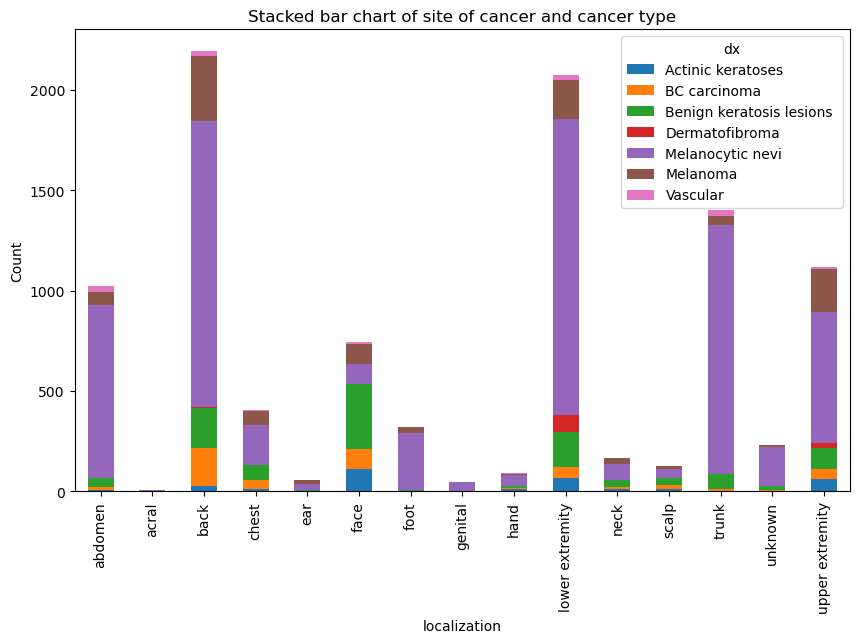

In [12]:
#lets see the freq of cancer rates by age and grouped via sex 
pd.crosstab(df['localization'], df['dx']).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked bar chart of site of cancer and cancer type')
plt.ylabel('Count')
plt.show()

Looks like based on the number of Melanocytic nevi that there is a clear bias in a sample size. The largest counts of our data have been sampled from patient backs - probably the most common site site melanomas etc - so no surprise there.

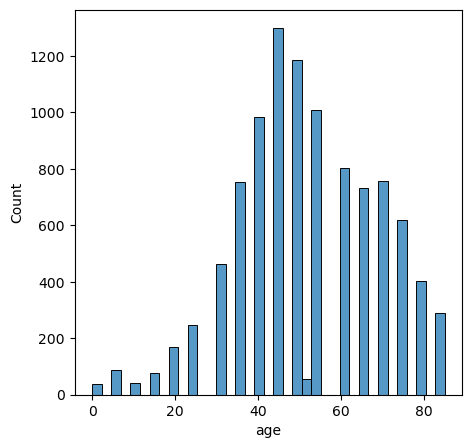

In [13]:
#Lets also look at the age of patients
plt.figure(figsize=(5,5))
sns.histplot(x='age',data=df)
plt.show()

In [14]:
df['age'].median(), df['age'].mean()

(50.0, 51.863828077927295)

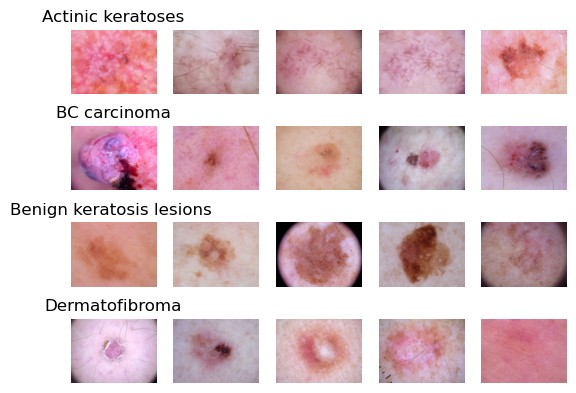

In [15]:
# lets have a look at some cancer affected images
fig, ax = plt.subplots(4,5)
for row_ax, (name,rows) in zip(ax, df.sort_values(by='dx').groupby('dx')):
    row_ax[0].set_title(name)
    for col_ax, (_, cols) in zip(row_ax, rows.sample(5).iterrows()):
        col_ax.imshow(cols['image'])
        col_ax.axis('off')